In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch_geometric
import torch_geometric.nn as geo_nn
from torch_geometric.data import Data
from torch_geometric.loader import ClusterData, ClusterLoader

In [3]:
from torchvision import datasets, transforms
from torch.nn import BCEWithLogitsLoss
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import gc
import psutil
import time

from util.CustomDatasets import PatientDataset
from util.GCN_GAT import GCN_GAT

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

SEED=79
torch.manual_seed(SEED);

In [4]:
all_patients_dict = torch.load('./data/adj_graph/img_dict.pth')
keys_temp = list(all_patients_dict.keys())[:10]

patient_max = None
max_edges = 0
total_nodes = 0
for k in all_patients_dict.keys():
    if k in keys_temp:
        print(f"{k}: total edges: {len(all_patients_dict[k]['edge_list'][0])} total nodes: {len(all_patients_dict[k]['enc'])}")
    if(len(all_patients_dict[k]['edge_list'][0]) > max_edges):
        max_edges = len(all_patients_dict[k]['edge_list'][0])
        patient_max = k
    total_nodes += len(all_patients_dict[k]['enc'])
print(f'\n{patient_max=}, edges: {max_edges}')
print(f'Mean nodes: {total_nodes / len(all_patients_dict.keys())}')
print(f'Amt keys: {len(all_patients_dict.keys())}')

001_01: total edges: 7400 total nodes: 1047
001_02: total edges: 6208 total nodes: 875
001_03: total edges: 1756 total nodes: 264
001_04: total edges: 1238 total nodes: 187
001_05: total edges: 1612 total nodes: 236
001_06: total edges: 2320 total nodes: 334
002_01: total edges: 9914 total nodes: 1357
002_02: total edges: 5800 total nodes: 850
002_03: total edges: 5924 total nodes: 879
002_04: total edges: 4308 total nodes: 629

patient_max='051_01', edges: 23720
Mean nodes: 695.802371541502
Amt keys: 506


In [5]:
SPLIT = [406, 50, 50] 
dataset = PatientDataset(all_patients_dict)

train_set, val_set, test_set = torch.utils.data.random_split(dataset,
                                                SPLIT,      # 80%, 10%, 10%
                                                generator=torch.Generator(device=device))


# batch_size MUST BE 1
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, generator=torch.Generator(device))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1)

In [6]:
# model = torch.load(MODEL_PATH)
fname = '7_13_2025'
MODEL_PATH = f'./models/gnn_class_models/{fname}.pth'

model = torch.load(MODEL_PATH)

In [8]:
pred = []
probs = []
labels = []
inps = []

precision_scores = []
recall_scores = []


model.eval()
for test_batch in val_loader:
    # Get info from the loader
    k = test_batch[0][0] # patient id
    v = test_batch[1] # dict with 'enc', 'label', 'edge_list'
    src, dest = v['edge_list'] # edges for the graph

    # Get embedding and label, format them and edges
    node_emb = v['enc'].squeeze(0)
    label = v['label'].squeeze(0)
    edge_index = torch.tensor([src, dest], dtype=torch.long)

    # Create data variable, and validate
    data = Data(x=node_emb, edge_index=edge_index.contiguous()).to(device)
    inps.append(data)

    with torch.no_grad():
        logit = model(data)
        prob = torch.sigmoid(logit)

        pred.append((prob > 0.5).float().item())
        labels.append(label.item())
        probs.append(prob.item())


print(f'Accuracy: {metrics.accuracy_score(labels, pred)}')

Accuracy: 0.7


In [9]:
precision, recall, thresholds = metrics.precision_recall_curve(labels, probs)
auc = metrics.auc(recall, precision)

In [10]:
thresholds += [0.5]

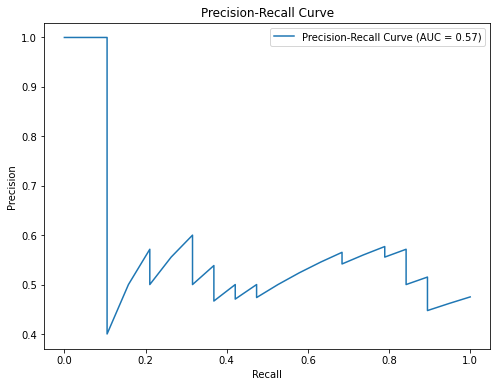

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

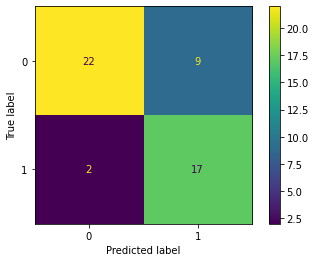

In [9]:
cm = metrics.confusion_matrix(labels, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [11]:
pred = []
labels = []

model.eval()
for test_batch in val_loader:
    # Get info from the loader
    k = test_batch[0][0] # patient id
    v = test_batch[1] # dict with 'enc', 'label', 'edge_list'
    src, dest = v['edge_list'] # edges for the graph
    
    # Get embedding and label, format them and edges
    node_emb = v['enc'].squeeze(0)
    label = v['label'].squeeze(0)
    edge_index = torch.tensor([src, dest], dtype=torch.long)

    # Create data variable, and validate
    data = Data(x=node_emb, edge_index=edge_index.contiguous()).to(device)
    
    with torch.no_grad():
        logit = model(data)
        pred.append((torch.sigmoid(logit) > 0.5).float().item())
        labels.append(label.item())
        
metrics.accuracy_score(labels, pred)

0.78

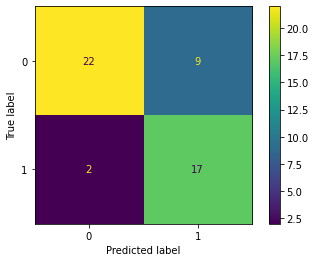

In [12]:
cm = metrics.confusion_matrix(labels, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [13]:
print(metrics.classification_report(labels,pred))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80        31
           1       0.65      0.89      0.76        19

    accuracy                           0.78        50
   macro avg       0.79      0.80      0.78        50
weighted avg       0.82      0.78      0.78        50



In [14]:
pred = []
labels = []

model.eval()
for test_batch in train_loader:
    # Get info from the loader
    k = test_batch[0][0] # patient id
    v = test_batch[1] # dict with 'enc', 'label', 'edge_list'
    src, dest = v['edge_list'] # edges for the graph
    
    # Get embedding and label, format them and edges
    node_emb = v['enc'].squeeze(0)
    label = v['label'].squeeze(0)
    edge_index = torch.tensor([src, dest], dtype=torch.long)

    # Create data variable, and validate
    data = Data(x=node_emb, edge_index=edge_index.contiguous()).to(device)
    
    with torch.no_grad():
        logit = model(data)
        pred.append((torch.sigmoid(logit) > 0.5).float().item())
        labels.append(label.item())
        
metrics.accuracy_score(labels, pred)

1.0

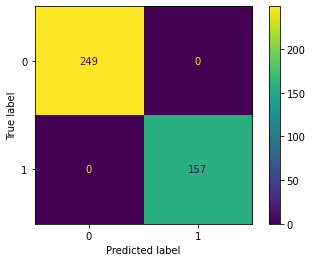

In [15]:
cm = metrics.confusion_matrix(labels, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [16]:
print(metrics.classification_report(labels,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       249
           1       1.00      1.00      1.00       157

    accuracy                           1.00       406
   macro avg       1.00      1.00      1.00       406
weighted avg       1.00      1.00      1.00       406

